In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10,6
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.preprocessing import StandardScaler

In [18]:
#数据导入
filename = r'G:\科研\人工智能\机器学习\机器学习\data.csv'
data=pd.read_csv(filename,encoding='gbk')

In [19]:
data_final=data.drop(['Unnamed: 0','custid','trade_no','id_name','latest_query_time','loans_latest_time','bank_card_no','source'], axis=1)
data_final.shape
for cl in data_final.columns:
    count = data_final[cl].count()
    if len(list(data_final[cl].unique())) in [1, count, count-1]:
        data_final.drop(cl, axis=1, inplace=True)


In [20]:
data_final['reg_preference_for_trad'].replace({'一线城市':1,'二线城市':2,'三线城市':3,'境外':4,'其他城市':5},inplace=True)
data_final.dtypes
data_final['student_feature'] = data_final['student_feature'].fillna(0)

In [21]:
data_final.fillna(data_final.median(), inplace=True)

In [22]:
# 将object类型转成folat
data_final=data_final.convert_objects(convert_numeric=True)
X = data_final.drop(["status"],axis=1)
Y = data_final["status"]
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.3, random_state=2018)
print(X_train.shape)
print(X_test.shape)
from sklearn.preprocessing import minmax_scale
# 归一化，缩放到0-1
standardScaler = StandardScaler()
X_train_fit = standardScaler.fit_transform(X_train)
X_test_fit = standardScaler.transform(X_test)

(3327, 81)
(1427, 81)


{'C': 1, 'penalty': 'l1'}
Logistic Regression 精确度 (accuracy):0.61
Logistic Regression 准确度(precision):0.35
Logistic Regression F1 Score :0.46
Logistic Regression 召回率(recall Score):0.67
Logistic Regression auc Score:0.63


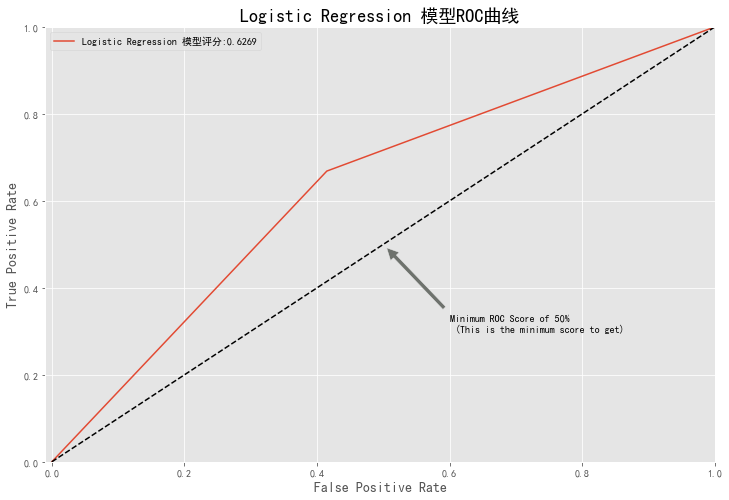

In [ ]:
def model_adjustment_optimization_score(X_train,X_test,y_train,y_test):
    """
    模型调优和评价
    
    """
    metrics_score = []
    metrics_score.append(logistic_model_adjustment_optimization_score(X_train,X_test,y_train,y_test))
    metrics_score.append(svc_model_adjustment_optimization_score(X_train,X_test,y_train,y_test))
    metrics_score.append(tree_model_adjustment_optimization_score(X_train,X_test,y_train,y_test))
    metrics_score.append(random_forest_model_adjustment_optimization_score(X_train,X_test,y_train,y_test))
    metrics_score.append(xgboost_model_adjustment_optimization_score(X_train,X_test,y_train,y_test))
    print(metrics_score)

def logistic_model_adjustment_optimization_score(X_train,X_test,y_train,y_test):
    """
    逻辑回归模型优化调参 LogisiticRegression
    通过网格搜索最优参数
    """
    log_reg_params = {'penalty':['l1','l2'],'C':[1e-3,1e-2,1e-1,1,1e+1,1e+2,1e+3]}
    return model_adjustment_optimization(LogisticRegression(),'Logistic Regression',log_reg_params,X_train,X_test,y_train,y_test)

def svc_model_adjustment_optimization_score(X_train,X_test,y_train,y_test):
    """
    支持向量机 Support Vector Machine
    """
    svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
    return model_adjustment_optimization(SVC(),'Support Vector Machine',svc_params,X_train,X_test,y_train,y_test)
    
def tree_model_adjustment_optimization_score(X_train,X_test,y_train,y_test):   
    """
    决策树  Decision Tree
    """
    tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), "min_samples_leaf": list(range(5,7,1))}
    return model_adjustment_optimization(DecisionTreeClassifier(),'Decision Tree',tree_params,X_train,X_test,y_train,y_test) 

def random_forest_model_adjustment_optimization_score(X_train,X_test,y_train,y_test):
    """
    随机森林 RandomForestClassifier
    """
    rfc_params = {'n_estimators':range(10,100,10),'criterion':['gini','entropy'],'min_samples_leaf':[2, 4, 6],'max_features':['auto', 'sqrt', 'log2']}
    return model_adjustment_optimization(RandomForestClassifier(),'Random Forest', rfc_params,X_train,X_test,y_train,y_test)

def xgboost_model_adjustment_optimization_score(X_train,X_test,y_train,y_test): 
    """
    可伸缩灵活梯度提升 XGBoost
    """       
    xgb_params = {'max_depth':range(4,6,1), 'min_child_weight':range(4,12,2), 'gamma' : [i/10 for i in range(0,5)], 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]}
    return model_adjustment_optimization(XGBClassifier(), 'XGBoost', xgb_params, X_train, X_test, y_train, y_test)
    
def model_adjustment_optimization(model,model_name,param_grid,X_train,X_test,y_train,y_test):
    """
    训练模型
    获取最优模型
    """
    kfold = KFold(n_splits=5)
    grid_svc = GridSearchCV(model, param_grid = param_grid, cv=kfold, n_jobs=-1, scoring='roc_auc')
    grid_svc.fit(X_train, y_train)
    svc_best_estimator = grid_svc.best_estimator_
    print(grid_svc.best_params_)
    
    # 通过最优模型来训练
    ms = model_score_auc_curve(svc_best_estimator, model_name, X_test, y_test)
    return ms    

    
def model_score_auc_curve(model,model_name,X_test,y_test):    
    """
    用于输出模型评分
    和
    绘制ROC曲线
    input:
        model:模型
        model_name:模型名称
        X_test:
        y_test:
    output: 返回各项评分指标
        accuracy:
        precision:
        f1:
        recall:
        auc:
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred)
    
    print('{} 精确度 (accuracy):{:.2f}'.format(model_name,accuracy))
    print('{} 准确度(precision):{:.2f}'.format(model_name,precision))
    print('{} F1 Score :{:.2f}'.format(model_name,f1))
    print('{} 召回率(recall Score):{:.2f}'.format(model_name,recall))
    print('{} auc Score:{:.2f}'.format(model_name,auc))
    
    fpr,tpr,threshold = roc_curve(y_test,y_pred)
    plt.figure(figsize=(12,8))
    plt.title('{} 模型ROC曲线'.format(model_name), fontsize=18)
    plt.plot(fpr,tpr,label='{} 模型评分:{:.4f}'.format(model_name,roc_auc_score(y_test,y_pred)))    
    plt.plot([0,1],[0,1],'k--')
    plt.axis([-0.01,1,0,1])
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)',xy=(0.5,0.5),
            xytext=(0.6,0.3),arrowprops=dict(facecolor='#6E726D', shrink=0.05))
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc='best')
    plt.show()
    ms = {}
    ms['model_name'] = model_name
    ms['accuracy'] = accuracy
    ms['precision'] = precision
    ms['f1'] = f1
    ms['recall'] = recall
    ms['auc'] = auc
    return ms
    

def main():
    # 1.1 加载切分后的数据集
    X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.3, random_state=2018)
    X_train_= standardScaler.fit_transform(X_train)
    X_test= standardScaler.transform(X_test)
    
    # 2.1 通过模型调参优化模型
    model_adjustment_optimization_score(X_train,X_test,y_train,y_test)
    
    

if __name__ == '__main__':
    main()